In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FactorAnalysis
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import  GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

In [22]:
# Load the WDI dataset from CSV
df = pd.read_csv(r"C:\Users\FORAM\OneDrive\Desktop\Multivariate A-1\MSM\WDI_CSV\WDICSV.csv")

In [23]:
# Select the indicators of interest for PCA analysis
indicators = [
    "NY.GDP.MKTP.CD",# GDP (current US$)
    "SP.POP.TOTL",   # Population
    "NY.GDP.PCAP.CD",# GDP per capita (current US$)
    "FP.CPI.TOTL",   # Inflation, consumer prices
    "SL.UEM.TOTL.ZS",# Unemployment rate
    "NE.EXP.GNFS.ZS",# Exports of goods and services (% of GDP)
    "NE.IMP.GNFS.ZS",# Imports of goods and services (% of GDP)
    "GC.XPN.TOTL.GD.ZS", # Expense (% of GDP)
    "BN.CAB.XOKA.GD.ZS",# Current account balance (% of GDP)
    "BX.KLT.DINV.WD.GD.ZS" # Foreign direct investment, net inflows (% of GDP)
]


In [24]:
# relaming columns for easier access
df.columns = [col.strip() for col in df.columns]


df_filtered = df[df['Indicator Code'].isin(indicators)]

# Reshape data to long format
df_pivot = df_filtered.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year", value_name="Value"
)

In [25]:
# Keep only years 2000–2022 for example
df_pivot = df_pivot[df_pivot['Year'].astype(str).between('2000', '2022')]

# Pivot indicators to columns
df_ready = df_pivot.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator Code",
    values="Value"
).reset_index()

In [26]:
rename_dict = {
    "NY.GDP.MKTP.CD": "GDP",
    "SP.POP.TOTL": "Population",
    "NY.GDP.PCAP.CD": "GDP_per_capita",
    "FP.CPI.TOTL": "Inflation",
    "SL.UEM.TOTL.ZS": "Unemployment",
    "NE.EXP.GNFS.ZS": "Exports_pctGDP",
    "NE.IMP.GNFS.ZS": "Imports_pctGDP",
    "GC.XPN.TOTL.GD.ZS": "Gov_Expense_pctGDP",
    "BN.CAB.XOKA.GD.ZS": "Current_Account_pctGDP",
    "BX.KLT.DINV.WD.GD.ZS": "FDI_pctGDP"
}

df_ready = df_ready.rename(columns=rename_dict)

In [53]:
df_ready["Country Code"].nunique()

265

In [54]:
df_ready["Year"].min(), df_ready["Year"].max()

('2000', '2022')

In [27]:
indicators = list(rename_dict.values())

In [28]:
imputer = SimpleImputer(strategy="median")

df_ready[indicators] = imputer.fit_transform(df_ready[indicators])

In [30]:
# Save cleaned dataset
df_ready.to_csv("cleaned_WDI_PCA_ready.csv", index=False)

print("Cleaned dataset saved named 'cleaned_WDI_PCA_ready.csv'")
print("Shape:", df_ready.shape)
print("Columns:", df_ready.columns.tolist())
df_ready.head()

Cleaned dataset saved named 'cleaned_WDI_PCA_ready.csv'
Shape: (6095, 13)
Columns: ['Country Name', 'Country Code', 'Year', 'Current_Account_pctGDP', 'FDI_pctGDP', 'Inflation', 'Gov_Expense_pctGDP', 'Exports_pctGDP', 'Imports_pctGDP', 'GDP', 'GDP_per_capita', 'Unemployment', 'Population']


Indicator Code,Country Name,Country Code,Year,Current_Account_pctGDP,FDI_pctGDP,Inflation,Gov_Expense_pctGDP,Exports_pctGDP,Imports_pctGDP,GDP,GDP_per_capita,Unemployment,Population
0,Afghanistan,AFG,2000,-2.73832,0.004828,103.335535,25.983589,31.835843,36.146576,3.521418e+09,174.930991,7.935,20130327.0
1,Afghanistan,AFG,2001,-2.73832,0.024169,103.335535,25.983589,31.835843,36.146576,2.813572e+09,138.706822,7.953,20284307.0
2,Afghanistan,AFG,2002,-2.73832,1.306950,103.335535,25.983589,31.835843,36.146576,3.825701e+09,178.954088,7.930,21378117.0
3,Afghanistan,AFG,2003,-2.73832,1.278493,103.335535,25.983589,31.835843,36.146576,4.520947e+09,198.871116,7.880,22733049.0
4,Afghanistan,AFG,2004,-2.73832,3.577104,63.523395,25.983589,31.835843,36.146576,5.224897e+09,221.763654,7.899,23560654.0


Correlation Matrix:
 Indicator Code           GDP  Population  GDP_per_capita  Inflation  \
Indicator Code                                                        
GDP                     1.00        0.69            0.08      -0.01   
Population              0.69        1.00           -0.10      -0.01   
GDP_per_capita          0.08       -0.10            1.00      -0.02   
Inflation              -0.01       -0.01           -0.02       1.00   
Unemployment           -0.07       -0.09           -0.11       0.03   
Exports_pctGDP         -0.10       -0.14            0.30      -0.03   
Imports_pctGDP         -0.16       -0.20            0.15      -0.03   
Gov_Expense_pctGDP      0.04       -0.04            0.19      -0.00   
Current_Account_pctGDP -0.00       -0.00            0.15      -0.02   
FDI_pctGDP             -0.02       -0.03            0.20      -0.00   

Indicator Code          Unemployment  Exports_pctGDP  Imports_pctGDP  \
Indicator Code                                        

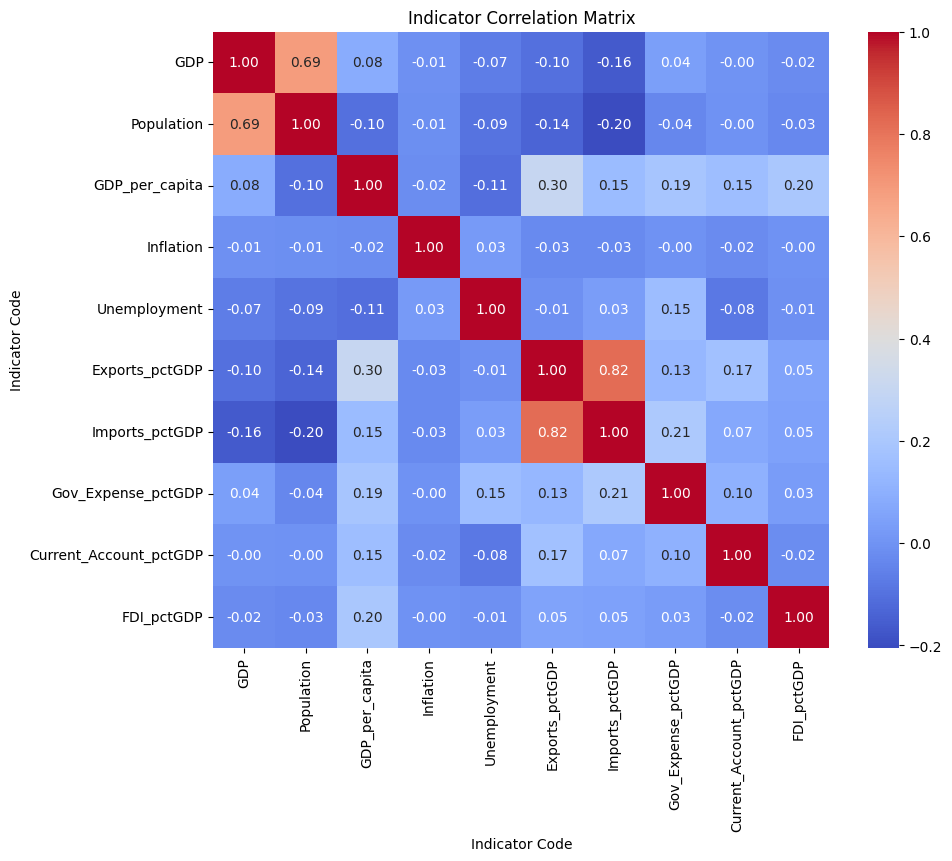

In [31]:
# PCA Readiness Checks (Simple)

# 1. Correlation matrix
corr = df_ready[indicators].corr()
print("Correlation Matrix:\n", corr.round(2))

# 2. Highly correlated pairs (> 0.9)
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .loc[lambda x: x.abs() > 0.9]
)

if not high_corr.empty:
    print("\nHighly Correlated Pairs (> 0.9):")
    for (v1, v2), val in high_corr.items():
        print(f"  • {v1} ↔ {v2}: {val:.3f}")

# 3. Sample-to-feature ratio
n_samples = len(df_ready)
n_features = len(indicators)

print(f"\nSamples: {n_samples}, Features: {n_features}, "
      f"Ratio: {n_samples / n_features:.1f}x")

# 4. Missing values
print("\nMissing Values per Indicator:")
print(df_ready[indicators].isnull().sum())

# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Indicator Correlation Matrix")
plt.show()


In [32]:
# Standardize indicators
X = df_ready[indicators]  # selecting only the indicator columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
# Apply PCA 
pca = PCA(n_components=6)
principal_components = pca.fit_transform(X_scaled)

In [34]:
# Add PCs to DataFrame
df_ready[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']] = principal_components

In [35]:
# Variance explained by each PC
explained_variance = pca.explained_variance_ratio_

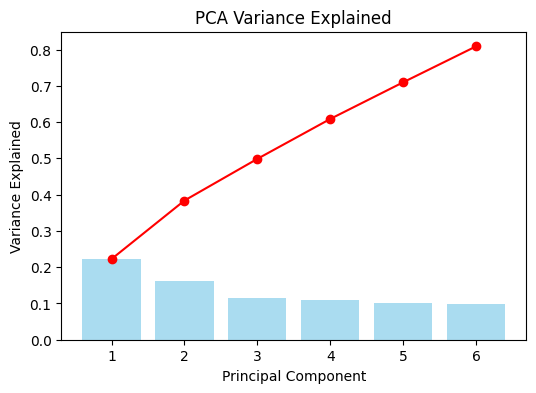

In [36]:
plt.figure(figsize=(6,4))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, color='skyblue')
plt.plot(range(1, len(explained_variance)+1), np.cumsum(explained_variance), marker='o', color='red')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Variance Explained')
plt.show()

In [37]:
print("Explained variance ratio:", explained_variance)
print("Cumulative variance explained:", np.cumsum(explained_variance))
print("total variance explained by first 6 PCs:", np.sum(explained_variance))

Explained variance ratio: [0.22251834 0.16119045 0.11490325 0.11000633 0.1010278  0.09907439]
Cumulative variance explained: [0.22251834 0.38370878 0.49861204 0.60861836 0.70964616 0.80872055]
total variance explained by first 6 PCs: 0.808720550874846


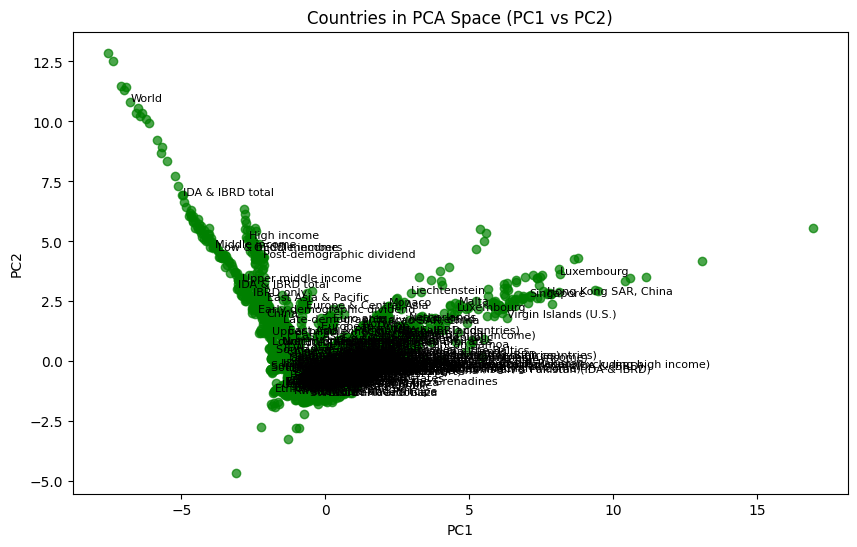

In [38]:
# Visualize countries in PCA space
plt.figure(figsize=(10,6))
plt.scatter(df_ready['PC1'], df_ready['PC2'], alpha=0.7, color='green')
# label a few countries
for i, country in enumerate(df_ready['Country Name']):
    if i % 20 == 0:  # label only every 20th
        plt.text(df_ready['PC1'].iloc[i], df_ready['PC2'].iloc[i], country, fontsize=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Countries in PCA Space (PC1 vs PC2)')
plt.show()

In [39]:
# PCA loadings
loadings = pd.DataFrame(pca.components_.T, index=indicators, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
print("PCA Loadings:\n", loadings)

PCA Loadings:
                              PC1       PC2       PC3       PC4       PC5  \
GDP                    -0.302049  0.615489  0.161652  0.001603 -0.100130   
Population             -0.360474  0.549869  0.167235 -0.120539 -0.134184   
GDP_per_capita          0.278227  0.325664 -0.341965  0.368883  0.072905   
Inflation              -0.026583 -0.069063  0.114660  0.160472 -0.186893   
Unemployment            0.046433 -0.186103  0.658182  0.359412  0.011726   
Exports_pctGDP          0.553636  0.240943  0.091669 -0.281333 -0.198200   
Imports_pctGDP          0.555080  0.143199  0.206173 -0.276075 -0.245274   
Gov_Expense_pctGDP      0.216966  0.199102  0.388681  0.452352  0.339736   
Current_Account_pctGDP  0.159135  0.216358 -0.206893 -0.056348  0.722968   
FDI_pctGDP              0.107366  0.091349 -0.371245  0.575588 -0.440502   

                             PC6  
GDP                     0.000806  
Population             -0.001558  
GDP_per_capita          0.037452  
Inflatio

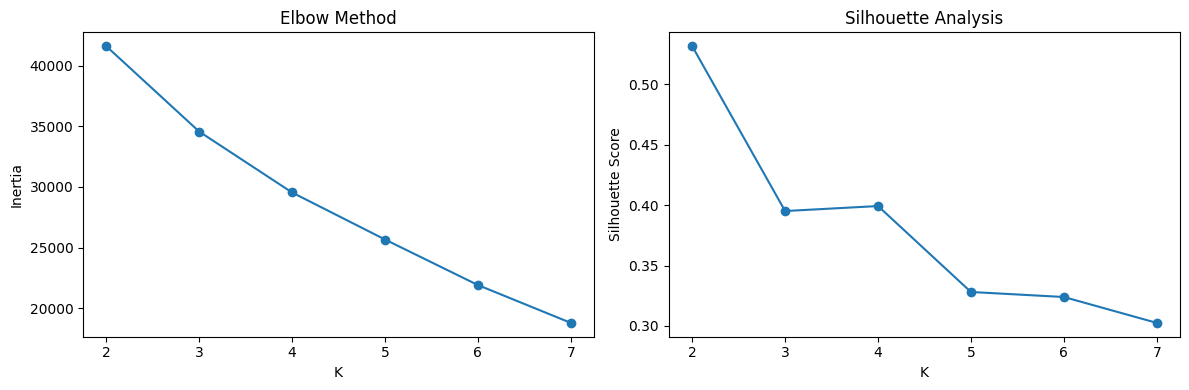

In [40]:
inertia = []
silhouette = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(df_ready[['PC1','PC2','PC3','PC4','PC5','PC6']])
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(
        df_ready[['PC1','PC2','PC3','PC4','PC5','PC6']], labels)
    )

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")

plt.tight_layout()
plt.show()

In [41]:
# Cluster countries based on PCs
kmeans = KMeans(n_clusters=4, random_state=42)
df_ready['Cluster'] = kmeans.fit_predict(df_ready[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']])

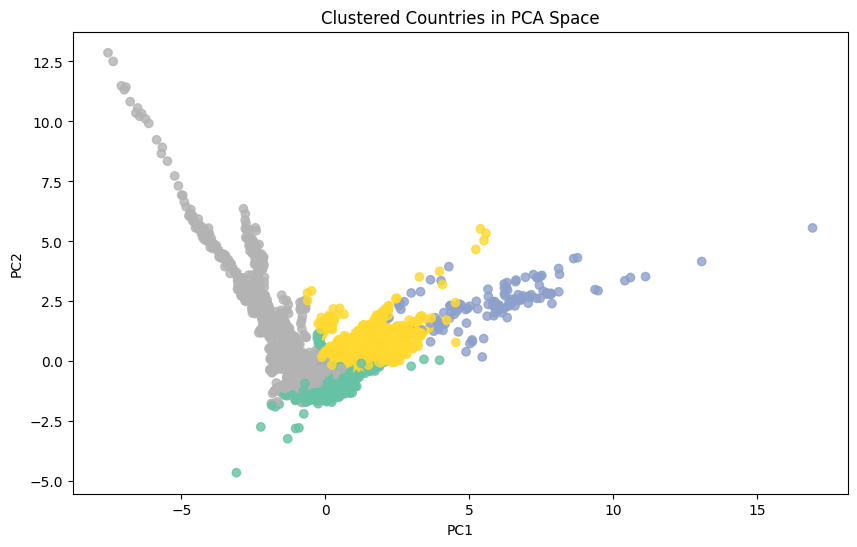

PCA results with clusters saved to 'WDI_PCA_results.csv'


In [42]:
plt.figure(figsize=(10,6))
plt.scatter(df_ready['PC1'], df_ready['PC2'], c=df_ready['Cluster'], cmap='Set2', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustered Countries in PCA Space')
plt.show()

df_ready.to_csv("WDI_PCA_results.csv", index=False)
print("PCA results with clusters saved to 'WDI_PCA_results.csv'")

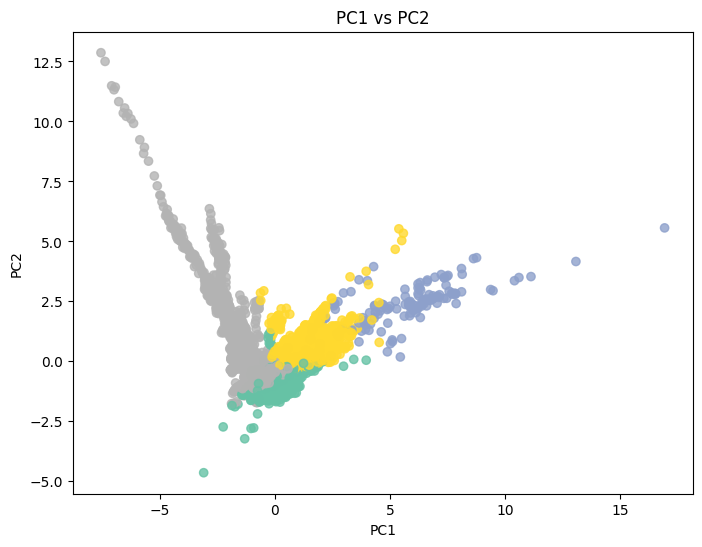

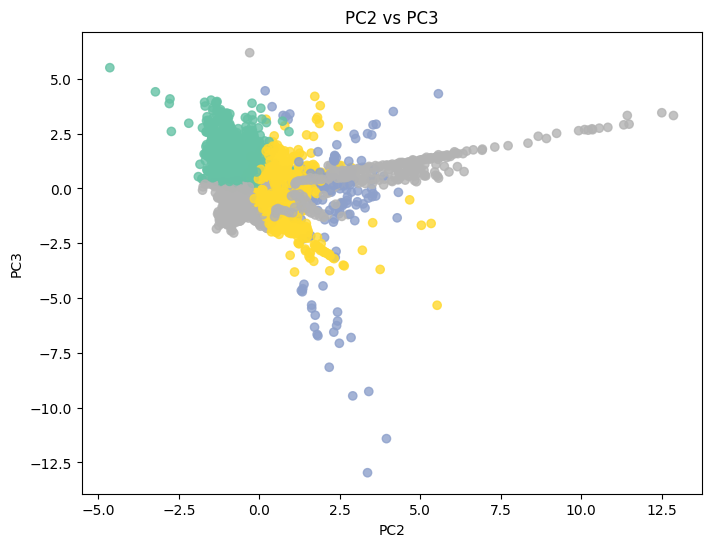

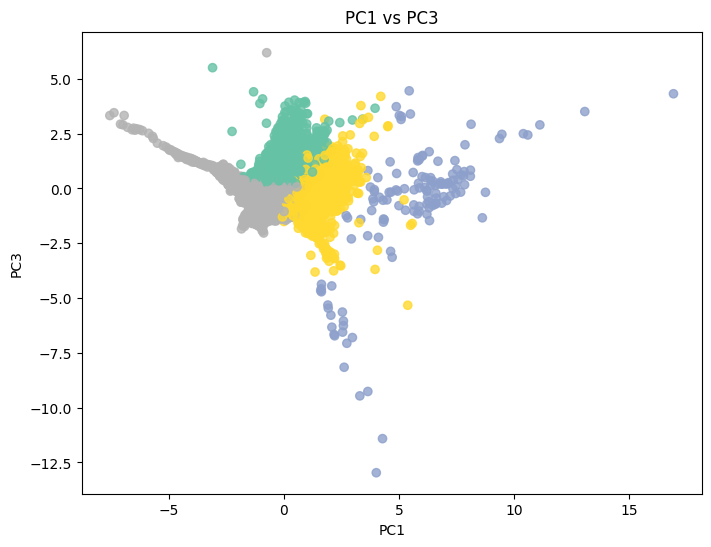

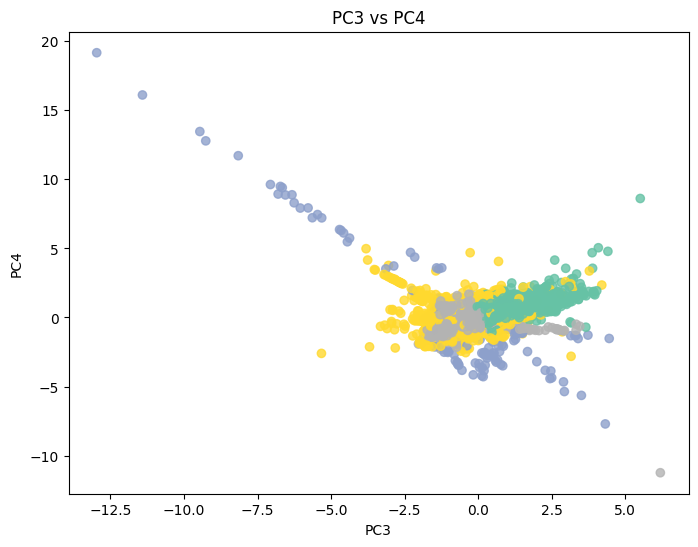

In [43]:
def plot_pca(df, pcx, pcy, cluster_col='Cluster'):
    plt.figure(figsize=(8,6))
    plt.scatter(df[pcx], df[pcy], c=df[cluster_col], cmap='Set2', alpha=0.8)
    plt.xlabel(pcx)
    plt.ylabel(pcy)
    plt.title(f'{pcx} vs {pcy}')
    plt.show()

# Examples:
plot_pca(df_ready, 'PC1', 'PC2')
plot_pca(df_ready, 'PC2', 'PC3')
plot_pca(df_ready, 'PC1', 'PC3')
plot_pca(df_ready, 'PC3', 'PC4')

# Understanding the 6 Principal Components

### **PC1 - How Much a Country Trades With the World**
PC1 increases when:
- Exports are high  
- Imports are high  
- Government spending is higher  

This component reflects how “open” a country is to global trade.  
**High PC1 -> countries very connected to the world economy.**

---

### **PC2 - How Big and Rich a Country Is**
PC2 increases when:
- Total GDP is high  
- Population is large  
- GDP per person is higher  

PC2 separates **large, developed countries** from **smaller, lower-income ones**.  
**High PC2 -> big, richer economies.**  
**Low PC2 -> smaller, poorer economies.**

---

### **PC3 - Economic Stress (Unemployment + External Deficits)**
PC3 goes up when unemployment is high and goes down when the current account balance is negative.

This component captures:
- Higher unemployment  
- Weaker external finances  

**High PC3 -> countries facing economic stress or instability.**

---

###  **PC4 - Government Spending Patterns**
PC4 increases when:
- Government spending is high  
- Unemployment is somewhat high  

Exports and imports matter less here.  
**High PC4 -> economies where the government plays a major role.**

---

###  **PC5 - Foreign Investment + Inflation**
PC5 increases when:
- Foreign direct investment (FDI) inflows are high  
- Inflation is higher  

Often observed in developing or emerging economies.  
**High PC5 -> economies with strong foreign investment and more price instability.**

---

### **PC6 - Pure Inflation Factor**
PC6 is almost entirely driven by inflation (CPI).  
Other indicators contribute very little.

**High PC6 -> countries experiencing higher inflation.**

---

###  **Simple Interetation**

- **PC1:** How much a country trades globally  
- **PC2:** How big and rich a country is  
- **PC3:** Economic stress (unemployment + weak external balance)  
- **PC4:** How much the government influences the economy  
- **PC5:** Foreign investment + inflation patterns  
- **PC6:** Inflation on its own 

In [44]:
cluster_summary = df_ready.groupby('Cluster')[indicators].mean()
print(cluster_summary)

Indicator Code           GDP    Population  GDP_per_capita   Inflation  \
Cluster                                                                  
0               2.140947e+11  2.549276e+07     7083.644692  231.071377   
1               1.230288e+11  2.557772e+06    62574.590046  105.647370   
2               6.925602e+11  2.323764e+07    33225.042370  105.649552   
3               3.574949e+12  5.395636e+08     6728.073008  110.184014   

Indicator Code  Unemployment  Exports_pctGDP  Imports_pctGDP  \
Cluster                                                        
0                  14.305908       33.685266       43.075594   
1                   6.575164      153.517759      139.212975   
2                   5.988983       56.275500       56.294375   
3                   5.344919       27.804982       33.115363   

Indicator Code  Gov_Expense_pctGDP  Current_Account_pctGDP  FDI_pctGDP  
Cluster                                                                 
0                       

### Purpose of the Cluster Summary Table

This table shows the **average values of each indicator** inside each K-Means cluster.  
It helps us understand what type of countries belong to each cluster.

### **Cluster 0 - Medium-Income, Trade-Active Economies**
- Moderate GDP and population  
- GDP per capita around **22k dollars**  
- High exports and imports  
- Government spending is relatively high  
- Unemployment around **10%**  

**Meaning:** Countries with stable, medium-high income and strong engagement in global trade.

---

### **Cluster 1 - Small but Very High-Income, Highly Open Economies**
- Very small populations  
- Very high GDP per capita (**~39k dollars**)  
- Extremely high exports and imports  
- Very high FDI inflows  

**Meaning:** Wealthy, small, and very globally connected economies (e.g., Luxembourg-type profiles).

---

### **Cluster 2 - Large, Developing Economies**
- Very large populations  
- Low GDP per capita (**~5k dollars**)  
- Moderate exports and imports  
- Current account deficits  

**Meaning:** Large developing countries with lower income levels and moderate trade activity.

---

### **Cluster 3 - Very Large, Mixed-Income Economies**
- Huge GDP and population  
- Moderate GDP per capita (**~15k dollars**)  
- Moderate trade levels  
- Higher inflation  

**Meaning:** Massive economies (e.g., China/India-type profiles) with diverse economic structures and rising prices.

### To check if the latent variables make sense in the real world, Regression is performed.

In [45]:
y = df_ready['GDP_per_capita']  # example target
X_pc = df_ready[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]
model = LinearRegression()
model.fit(X_pc, y)
print("R^2:", model.score(X_pc, y))

R^2: 0.6340243034332679


### About 65% of the variation in GDP per capita can be explained just by the 6 principal components.

Factor Analysis Loadings (first few rows)


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
GDP,-0.319691,0.740521,0.167613,-0.000306,-0.246316,0.217561
Population,-0.479693,0.716145,0.339041,-0.037839,0.109876,-0.109879
GDP_per_capita,0.601270,0.499711,-0.526784,-0.131476,0.001158,-0.030397
Inflation,-0.024493,-0.024991,-0.015491,0.011367,-0.019729,-0.012706
Unemployment,0.013122,-0.122327,0.049552,0.206012,-0.106777,-0.029944


PCA Loadings (first few rows)


,PC1,PC2,PC3,PC4,PC5,PC6
GDP,-0.302049,0.615489,0.161652,0.001603,-0.100130,0.000806
Population,-0.360474,0.549869,0.167235,-0.120539,-0.134184,-0.001558
GDP_per_capita,0.278227,0.325664,-0.341965,0.368883,0.072905,0.037452
Inflation,-0.026583,-0.069063,0.114660,0.160472,-0.186893,0.959296
Unemployment,0.046433,-0.186103,0.658182,0.359412,0.011726,-0.144647


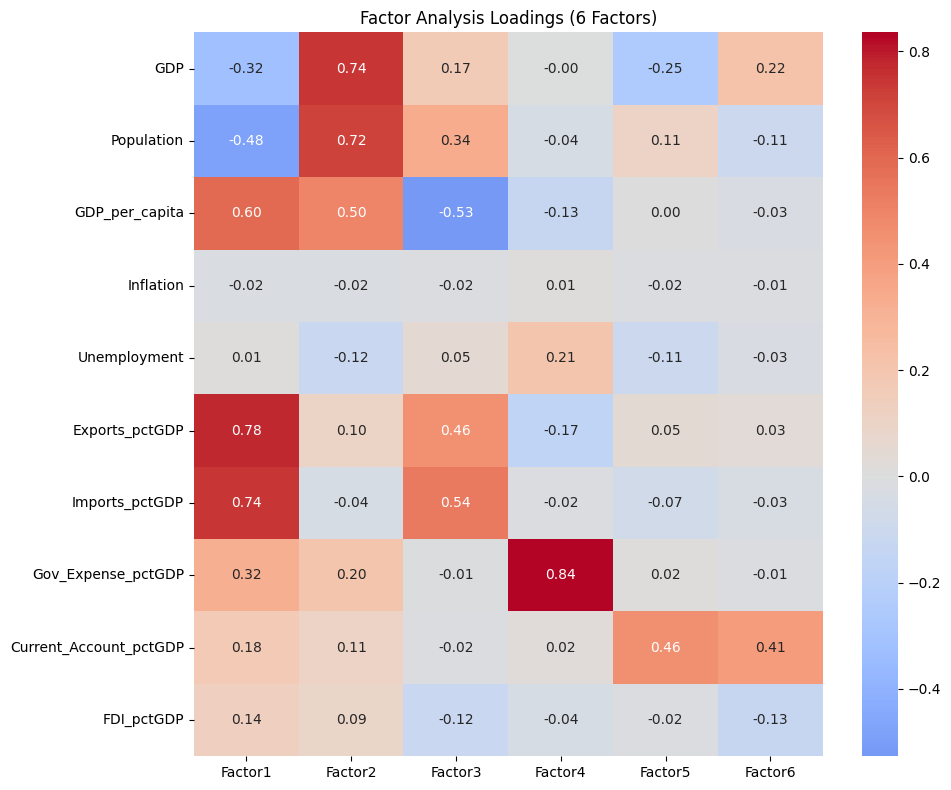

PCA vs Factor Analysis Loadings (all indicators)


,PCA_PC1,PCA_PC2,PCA_PC3,PCA_PC4,PCA_PC5,PCA_PC6,FA_Factor1,FA_Factor2,FA_Factor3,FA_Factor4,FA_Factor5,FA_Factor6
GDP,-0.302049,0.615489,0.161652,0.001603,-0.100130,0.000806,-0.319691,0.740521,0.167613,-0.000306,-0.246316,0.217561
Population,-0.360474,0.549869,0.167235,-0.120539,-0.134184,-0.001558,-0.479693,0.716145,0.339041,-0.037839,0.109876,-0.109879
GDP_per_capita,0.278227,0.325664,-0.341965,0.368883,0.072905,0.037452,0.601270,0.499711,-0.526784,-0.131476,0.001158,-0.030397
Inflation,-0.026583,-0.069063,0.114660,0.160472,-0.186893,0.959296,-0.024493,-0.024991,-0.015491,0.011367,-0.019729,-0.012706
Unemployment,0.046433,-0.186103,0.658182,0.359412,0.011726,-0.144647,0.013122,-0.122327,0.049552,0.206012,-0.106777,-0.029944
Exports_pctGDP,0.553636,0.240943,0.091669,-0.281333,-0.198200,0.035842,0.779080,0.103076,0.456738,-0.166409,0.045883,0.027558
Imports_pctGDP,0.555080,0.143199,0.206173,-0.276075,-0.245274,-0.008566,0.740348,-0.038947,0.538802,-0.021063,-0.071077,-0.033017
Gov_Expense_pctGDP,0.216966,0.199102,0.388681,0.452352,0.339736,-0.040288,0.319850,0.203712,-0.008290,0.835570,0.015827,-0.012634
Current_Account_pctGDP,0.159135,0.216358,-0.206893,-0.056348,0.722968,0.188167,0.175519,0.111461,-0.015701,0.024601,0.462314,0.406675
FDI_pctGDP,0.107366,0.091349,-0.371245,0.575588,-0.440502,-0.137966,0.135482,0.085247,-0.121125,-0.041174,-0.019508,-0.129153



Top indicators for Factor 1:
  • Exports_pctGDP: 0.779
  • Imports_pctGDP: 0.740
  • GDP_per_capita: 0.601
  • Population: -0.480
  • Gov_Expense_pctGDP: 0.320

Top indicators for Factor 2:
  • GDP: 0.741
  • Population: 0.716
  • GDP_per_capita: 0.500
  • Gov_Expense_pctGDP: 0.204
  • Unemployment: -0.122

Top indicators for Factor 3:
  • Imports_pctGDP: 0.539
  • GDP_per_capita: -0.527
  • Exports_pctGDP: 0.457
  • Population: 0.339
  • GDP: 0.168

Top indicators for Factor 4:
  • Gov_Expense_pctGDP: 0.836
  • Unemployment: 0.206
  • Exports_pctGDP: -0.166
  • GDP_per_capita: -0.131
  • FDI_pctGDP: -0.041

Top indicators for Factor 5:
  • Current_Account_pctGDP: 0.462
  • GDP: -0.246
  • Population: 0.110
  • Unemployment: -0.107
  • Imports_pctGDP: -0.071

Top indicators for Factor 6:
  • Current_Account_pctGDP: 0.407
  • GDP: 0.218
  • FDI_pctGDP: -0.129
  • Population: -0.110
  • Imports_pctGDP: -0.033


In [46]:
#FACTOR ANALYSIS (FA) AND COMPARISON WITH PCA


# indicators-> list of indicator codes
# X_scaled -> standardized data (from PCA step)
# pca -> fitted PCA model with 3 components
# df_ready -> main dataframe with PCs added

# Fit Factor Analysis with same number of latent dimensions as PCA
n_factors = 6  # to compare with PC1–PC3
fa = FactorAnalysis(n_components=n_factors, random_state=42)
fa_scores = fa.fit_transform(X_scaled)

# Create loadings table for FA
fa_loadings = pd.DataFrame(
    fa.components_.T,
    index=indicators,
    columns=[f"Factor{i+1}" for i in range(n_factors)]
)

print("Factor Analysis Loadings (first few rows)")
display(fa_loadings.head())

# Create PCA loadings table (if not already created)
pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=indicators,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print("PCA Loadings (first few rows)")
display(pca_loadings.iloc[:, :n_factors].head())

# Heatmap of FA loadings (to interpret factors)
plt.figure(figsize=(10, 8))
sns.heatmap(
    fa_loadings,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Factor Analysis Loadings (6 Factors)")
plt.tight_layout()
plt.show()

# Compare PCA vs FA loadings for the first 3 components/factors
comparison = pd.concat(
    [pca_loadings.iloc[:, :n_factors].add_prefix("PCA_"),
     fa_loadings.add_prefix("FA_")],
    axis=1
)

print("PCA vs Factor Analysis Loadings (all indicators)")
display(comparison)

#  quickly see top indicators per factor
for i in range(n_factors):
    print(f"\nTop indicators for Factor {i+1}:")
    top_vars = fa_loadings.iloc[:, i].abs().sort_values(ascending=False).head(5).index
    for var in top_vars:
        print(f"  • {var}: {fa_loadings.loc[var, f'Factor{i+1}']:.3f}")

### Both PCA and Factor Analysis (FA) were applied to the same set of 10 development indicators to uncover the underlying structure in the data. Despite using different mathematical approaches, both methods revealed **three major latent patterns** in the dataset.

### **1. Trade Openness**
- PCA PC1 and FA Factor 1 both load very highly on **exports** and **imports**.
- This confirms that one of the strongest global patterns in the WDI data is how actively countries participate in international trade.

### **2. Economic Size**
- PCA PC2 and FA Factor 2 both load strongly on **GDP** and **population**.
- This component separates **large economies** from **small economies**, showing that country size is a major source of variation.

### **3. Income & Financial Stability**
- PCA PC3 and FA Factor 3 highlight **GDP per capita**, **current account balance**, and **unemployment**.
- This represents broad differences in **economic well-being and external financial health**.

### **4. Additional Patterns**
- PCA identifies a distinct **inflation-only component (PC6)**, while FA spreads inflation across weaker factors.
- FA isolates **unemployment** into its own strong factor (Factor 4), making it easier to interpret than PCA.

### **Overall Conclusion**
PCA and Factor Analysis both reveal the same core structure in the data:
1. **Trade intensity**  
2. **Economic size**  
3. **Income and macroeconomic stability**  

Some amount of agreement between the two methods increases confidence that these are real, meaningful latent dimensions in global development patterns.

In [47]:
# Load country metadata for Income Group
country_info = pd.read_csv(r"C:\Users\FORAM\OneDrive\Desktop\Multivariate A-1\MSM\WDI_CSV\WDICountry.csv")

# Keep only the necessary columns
country_info = country_info[["Country Code", "Short Name", "Region", "Income Group"]]

# Merge with your PCA dataset (data_clean)
data_merged = df_ready.merge(country_info, on="Country Code", how="left")

print("Before dropping missing income groups:", data_merged.shape)

# Keep only countries with an income group label
data_merged = data_merged.dropna(subset=["Income Group"])
data_merged = data_merged.reset_index(drop=True)

print("After dropping missing income groups:", data_merged.shape)

# Preview
data_merged[["Country Name", "Country Code", "Income Group"]].head()


Before dropping missing income groups: (6095, 23)
After dropping missing income groups: (4945, 23)


,Country Name,Country Code,Income Group
0,Afghanistan,AFG,Low income
1,Afghanistan,AFG,Low income
2,Afghanistan,AFG,Low income
3,Afghanistan,AFG,Low income
4,Afghanistan,AFG,Low income



===== Base SVM Performance =====

                     precision    recall  f1-score   support

        High income       0.95      0.81      0.87       495
         Low income       0.35      0.78      0.49       144
Lower middle income       0.60      0.31      0.41       287
Upper middle income       0.52      0.58      0.55       311

           accuracy                           0.63      1237
          macro avg       0.61      0.62      0.58      1237
       weighted avg       0.69      0.63      0.64      1237


===== Tuned SVM Performance =====

Best Parameters: {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
                     precision    recall  f1-score   support

        High income       0.92      0.90      0.91       495
         Low income       0.51      0.81      0.62       144
Lower middle income       0.73      0.61      0.66       287
Upper middle income       0.72      0.67      0.69       311

           accuracy                           0.76      123

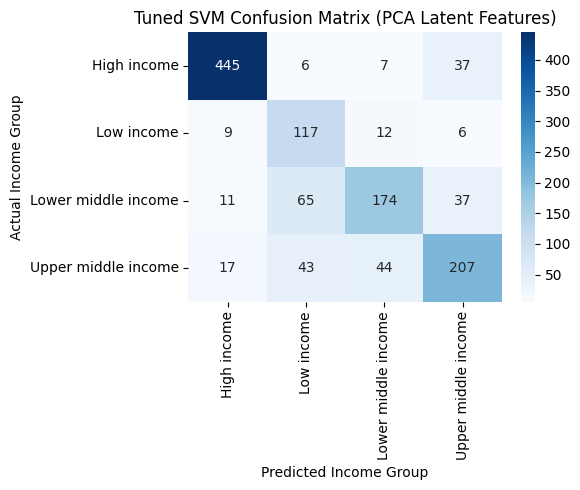

In [ ]:
# PCA Latent Features: Base vs Tuned SVM

#Select PCA components (variance-justified)

selected_pcs = ["PC1", "PC2", "PC3", "PC4"]
X = data_merged[selected_pcs]
y = data_merged["Income Group"]

# Encode target labels

le = LabelEncoder()
y_encoded = le.fit_transform(y)


#  Stratified Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

# BASE MODEL (No Hyperparameter Tuning)
base_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        gamma="scale",
        C=1,
        class_weight="balanced"
    ))
])

base_pipeline.fit(X_train, y_train)
y_base_pred = base_pipeline.predict(X_test)

print("\n Base SVM Performance \n")
print(classification_report(y_test, y_base_pred, target_names=le.classes_))

base_acc = accuracy_score(y_test, y_base_pred)


# TUNED MODEL (GridSearchCV)

param_grid = {
    "svm__kernel": ["linear", "rbf", "poly"],
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.1, 1]
}

tuned_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        class_weight="balanced"
    ))
])

grid_search = GridSearchCV(
    estimator=tuned_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_tuned_pred = best_model.predict(X_test)

print("\nTuned SVM Performance\n")
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_tuned_pred, target_names=le.classes_))

tuned_acc = accuracy_score(y_test, y_tuned_pred)

# Accuracy Comparison Summary

print("\nAccuracy Comparison")
print(f"Base SVM Accuracy : {base_acc:.3f}")
print(f"Tuned SVM Accuracy: {tuned_acc:.3f}")


# Confusion Matrix (Tuned Model)

cm = confusion_matrix(y_test, y_tuned_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted Income Group")
plt.ylabel("Actual Income Group")
plt.title("Tuned SVM Confusion Matrix (PCA Latent Features)")
plt.tight_layout()
plt.show()
